In [14]:
chosen_model = 'GRU' # 'RNN' 'LSTM' 'GRU'

In [15]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2.14.0


## Load Data

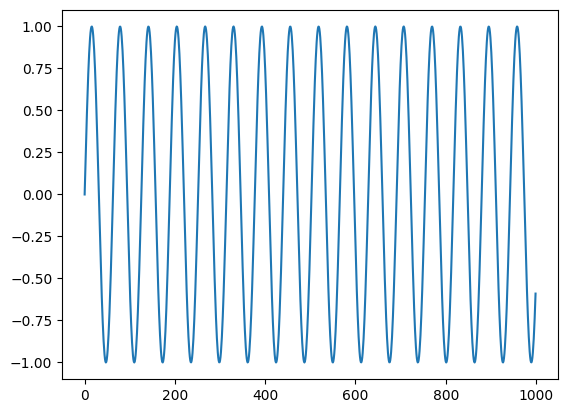

In [16]:
series = np.sin(0.1*np.arange(1000)) #+ np.random.randn(200)*0.1

# plot it
plt.plot(series)
plt.show()

In [17]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990,)


## Split Data

In [18]:
validation_index = N//2
X_train = X[:-validation_index]
X_valid = X[-validation_index:]
Y_train = Y[:-validation_index]
Y_valid = Y[-validation_index:]

X_train.shape, Y_train.shape

((495, 10, 1), (495,))

## Create the Model


In [19]:
i = Input(shape=X_train[0].shape)

if chosen_model == 'RNN':
  x = SimpleRNN(15, activation='relu')(i)
elif chosen_model == 'LSTM':
  x = LSTM(15, activation='relu')(i)
elif chosen_model == 'GRU':
  x = GRU(15, activation='relu')(i)

x = Dense(1)(x)

model = Model(i, x)

model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.001),
)

# train the RNN
r = model.fit(
  X_train, Y_train,
  validation_data=(X_valid, Y_valid),
  epochs=80,
  verbose=0
)

## Evaluate Model Performance


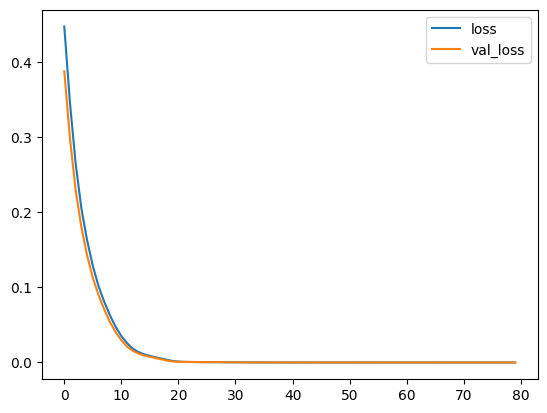

In [20]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

### Wrong Way to Forecast

In [21]:
validation_target = Y[-validation_index:]
validation_predictions = []

# index of first validation input
i = -validation_index
print(X[i].shape) # shape (T, 1). Remember, X.shape is 3D hence X[0].shape is 2D

while len(validation_predictions) < len(validation_target):
  two_dim_input = X[i]
  three_dim_input = X[i].reshape(1, -1, 1)
  two_dim_output = model.predict(three_dim_input, verbose=0)
  scalar_prediction = two_dim_output[0][0]
  i += 1

  # update the predictions list
  validation_predictions.append(scalar_prediction)

(10, 1)


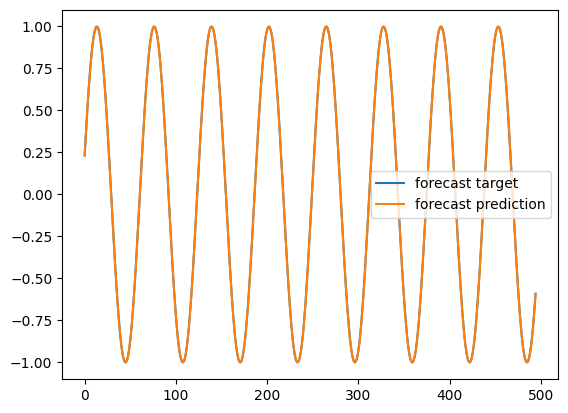

In [22]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

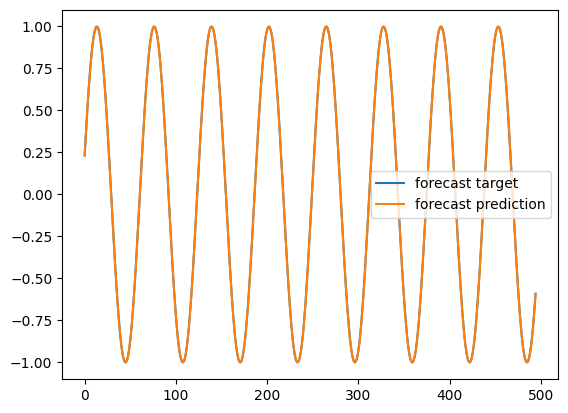

In [23]:
# Compare to Class Version

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1, 1), verbose=0)[0,0] # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()


### Correct Way of Predicting

In [24]:
validation_target = Y[-validation_index:]
validation_predictions = []

# first validation input
last_x = X[-validation_index] # 2-D array shape (T, 1)
print(last_x.shape)

while len(validation_predictions) < len(validation_target):
  two_dim_input = last_x
  three_dim_input = last_x.reshape(1, -1, 1)
  two_dim_output = model.predict(three_dim_input, verbose=0)
  scalar_prediction = two_dim_output[0][0]

  validation_predictions.append(scalar_prediction)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = scalar_prediction

(10, 1)


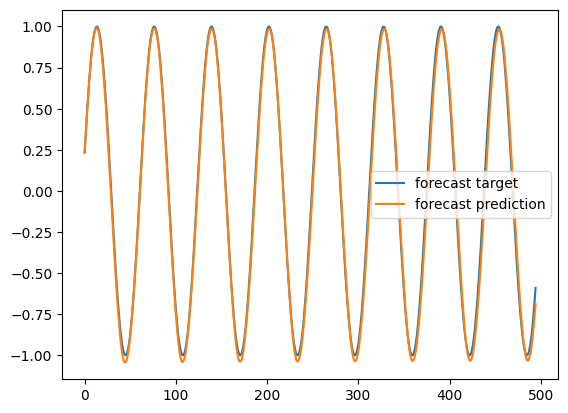

In [25]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()